In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from itertools import cycle
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing the data (same as in your code)
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
X_train = []
y_train = []
image_size = 80
for i in labels:
    folderPath = os.path.join('Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train, y_train = shuffle(X_train, y_train, random_state=101)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

100%|██████████| 74/74 [00:01<00:00, 59.30it/s]


In [3]:
# Data Augmentation
datagen = ImageDataGenerator(rotation_range=90, vertical_flip=True)

# Augment the training data and concatenate the original data with augmented data
X_train_augmented, y_train_augmented = [], []

for batch_X, batch_y in datagen.flow(X_train, y_train, batch_size=16, shuffle=False):
    X_train_augmented.append(batch_X)
    y_train_augmented.append(batch_y)
    if len(X_train_augmented) * 16 >= len(X_train):  # Stop after augmenting enough samples
        break

X_train_augmented = np.concatenate(X_train_augmented, axis=0)
y_train_augmented = np.concatenate(y_train_augmented, axis=0)

# Concatenate original and augmented data
X_train = np.concatenate((X_train, X_train_augmented), axis=0)
y_train = np.concatenate((y_train, y_train_augmented), axis=0)

# Convert labels to indices
y_train_new = [labels.index(i) for i in y_train]
y_train = tf.keras.utils.to_categorical(y_train_new, num_classes=len(labels))

y_test_new = [labels.index(i) for i in y_test]
y_test = tf.keras.utils.to_categorical(y_test_new, num_classes=len(labels))

In [4]:
# Flatten images for SVM
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten the images into vectors
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Flatten the test images

# Normalize the data
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

In [5]:
# SVM Model
svm_model = SVC(kernel='linear', probability=True)  # You can try other kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train_flat, y_train_new)  # Train the model on the flattened and scaled data

SVC(kernel='linear', probability=True)

In [6]:
# Predictions
pred = svm_model.predict(X_test_flat)
y_test_new = np.argmax(y_test, axis=1)

# Evaluation
print(classification_report(y_test_new, pred))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65        93
           1       0.71      0.69      0.70        51
           2       0.64      0.72      0.68        96
           3       0.93      0.92      0.92        87

    accuracy                           0.74       327
   macro avg       0.74      0.74      0.74       327
weighted avg       0.74      0.74      0.74       327



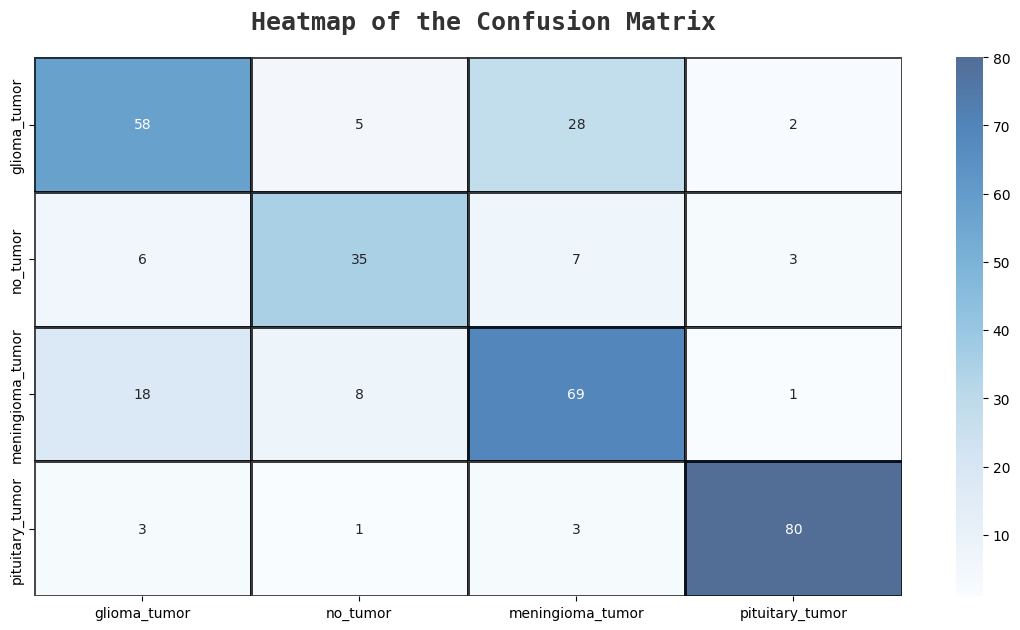

Test Accuracy: 74.01%


In [7]:
# Confusion Matrix
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(confusion_matrix(y_test_new, pred), ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            cmap='Blues', alpha=0.7, linewidths=2, linecolor='black')
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', color='black', y=0.92, x=0.28, alpha=0.8)
plt.show()

# Accuracy
accuracy = accuracy_score(y_test_new, pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

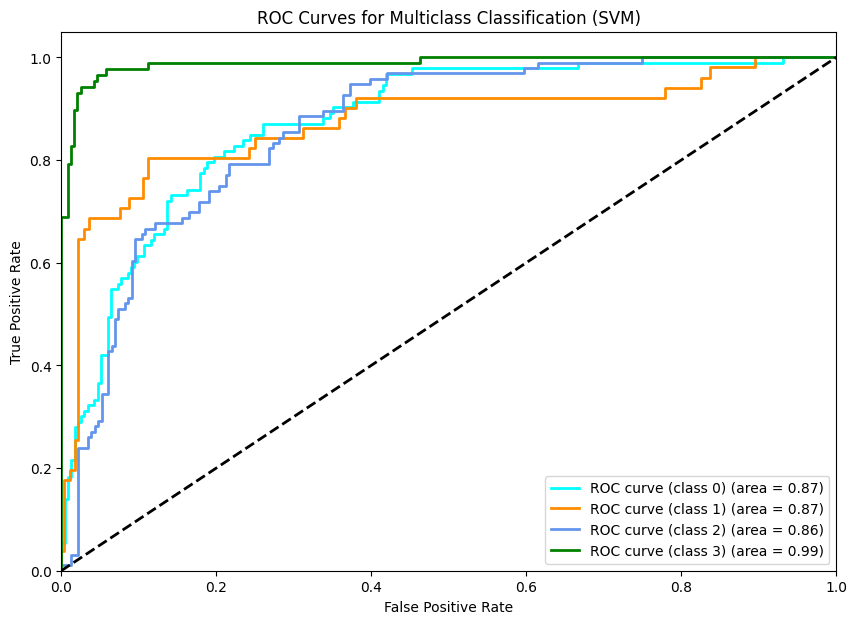

In [8]:
# ROC Curve
y_test_bin = label_binarize(y_test_new, classes=[0, 1, 2, 3])  # 4 classes: [0, 1, 2, 3]
n_classes = y_test_bin.shape[1]

# Get predicted probabilities
y_pred_prob = svm_model.predict_proba(X_test_flat)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 7))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')

# Plotting details
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification (SVM)')
plt.legend(loc="lower right")
plt.show()
